In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os
import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset

from torchnlp.metrics import get_moses_multi_bleu
from sacrebleu import raw_corpus_bleu

from matplotlib import colors
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
import math
from math import exp
import pickle as pkl

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
nowpath = os.path.abspath('.')
zh_en_dataDir = nowpath + '//dataset//iwsltzhen'
vi_en_dataDir = nowpath + '//dataset//iwsltvien'
emb_dataDir = nowpath + '//dataset//embedding'
res_dataDir = nowpath + '//results'
res_dataDir_vi = nowpath + '//results//vi_new_attn'
res_dataDir_zh = nowpath + '//results//zh_new_attn'

In [16]:
recursive_reader(res_dataDir_zh, dict_out, ['simple'], ['t1', 't2'])

In [8]:
def pkl_dumper(objct, file_name):
    with open(file_name, 'wb+') as f:
        pkl.dump(objct, f, protocol=None)

def pkl_loader(file_name):
    with open(file_name, 'rb') as f:
        objct = pkl.load(f, encoding = 'bytes')
    return(objct)

In [9]:
def recursive_reader(datadir, dict_out, list_include, list_exclude, datadir_exclude='DoNotExcludeMe'):
    def recursiver(root, name, list_include, list_exclude):
        # print(name)
        if list_include == []:
            if list_exclude == []:
                return(True)
            elif list_exclude.pop() not in name:
                # print('T LE:{}'.format(list_exclude))
                return(recursiver(root, name, list_include, list_exclude))
            else:
                # print('F LE:{}'.format(list_exclude))
                return(False)
        elif list_include.pop() in name:
            # print('T LI:{}'.format(list_include))
            return(recursiver(root, name, list_include, list_exclude))
        else:
            # print('F LI:{}'.format(list_include))
            return(False)
    for root, dirs, files in os.walk(datadir, topdown=False):
        if datadir_exclude in root:
            continue
        for name in files:
            if name.endswith('.p') and recursiver(root, name, list_include[:], list_exclude[:]):
                print(root+'//'+name)
                try:
                    dict_out[name] = pkl_loader(root+'//'+name)
                    dict_out[name] = list(zip(*dict_out[name]))
                    if 'val' in name:
                        dict_out[name][1] = [x.item() for x in dict_out[name][1]]
                except:
                    continue
            # break
                

In [32]:
ece = [colors.to_rgba(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]

In [33]:
ece

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)]

In [10]:
def loss_plotter(dict_in, title):
    color_list = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'pink'] + \
                [colors.to_rgba(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
    firstVal = -1
    fig1, ax1 = plt.subplots(figsize=(12, 8))
    fig2, ax2 = plt.subplots(figsize=(12, 8))
    lines_t, lines_v = {}, {}
    for i, key in enumerate(sorted(dict_in.keys())):
        if 'train' in key:
            cur_lab = key.split('_')[-2]
            lines_t[key], = ax1.plot(np.array(list(range(len(dict_in[key][0]))))/len(dict_in[key][0])*15, \
                                     dict_in[key][1], '-', label='train, hidden_size:{}'.format(cur_lab), color = color_list[i])
        elif 'val' in key:
            if firstVal == -1:
                firstVal = i
            cur_lab = key.split('_')[-2]
            lines_v[key], = ax2.plot(np.array(list(range(len(dict_in[key][0]))))/len(dict_in[key][0])*15, \
                                     dict_in[key][2], '-', label='hidden_size:{}'.format(cur_lab), color = color_list[i-firstVal])
            lines_t[key], = ax1.plot(np.array(list(range(len(dict_in[key][0]))))/len(dict_in[key][0])*15, \
                                     dict_in[key][1], '--', label='val, hidden_size:{}'.format(cur_lab), color = color_list[i-firstVal])
    legend1 = ax1.legend(loc='upper left', shadow=True)
    legend2 = ax2.legend(loc='upper left', shadow=True)
    ax1.set_ylabel('Train Loss')
    ax2.set_ylabel('Val BLEU Score')
    ax1.set_title('Train Loss, model: {}'.format(title))
    ax2.set_title('Val BLEU Score, model: {}'.format(title))
    ax1.set_xlabel('Epochs')
    ax2.set_xlabel('Epochs')

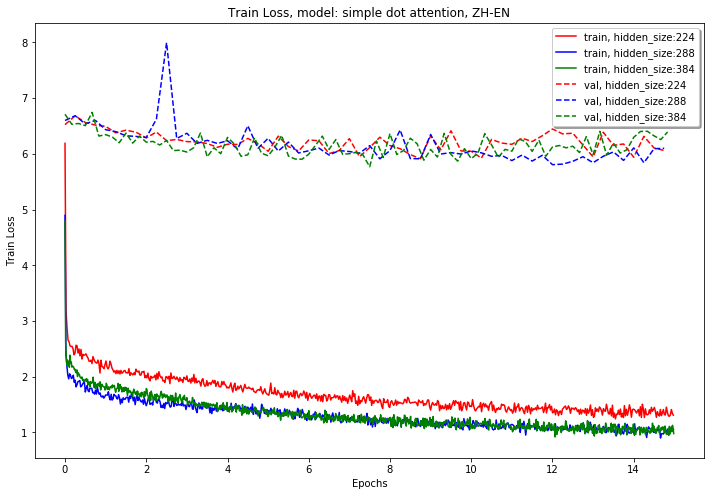

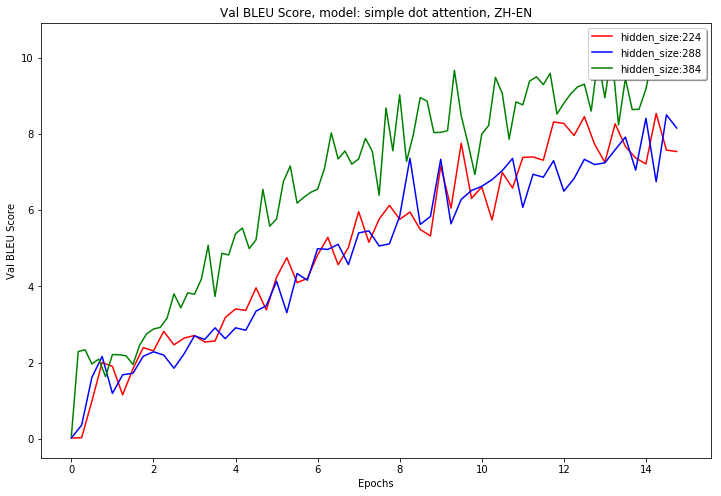

In [90]:
loss_plotter(dict_out, 'simple dot attention, ZH-EN')

In [81]:
dict_out_W = {}

In [82]:
recursive_reader(res_dataDir_zh, dict_out_W, [], ['simple', 't1', 't2'])

/beegfs/fs1520/NLP/project//results//zh_new_attn//zh_valLoss_1207_300_480_10.p
/beegfs/fs1520/NLP/project//results//zh_new_attn//zh_trainLoss_1207_300_480_10.p
/beegfs/fs1520/NLP/project//results//zh_new_attn//zh_valLoss_1209_300_288_10.p
/beegfs/fs1520/NLP/project//results//zh_new_attn//zh_valLoss_1208_300_768_10.p
/beegfs/fs1520/NLP/project//results//zh_new_attn//zh_valLoss_1208_300_384_10.p
/beegfs/fs1520/NLP/project//results//zh_new_attn//zh_trainLoss_1208_300_768_10.p
/beegfs/fs1520/NLP/project//results//zh_new_attn//zh_trainLoss_1208_300_384_10.p
/beegfs/fs1520/NLP/project//results//zh_new_attn//zh_trainLoss_1209_300_288_10.p


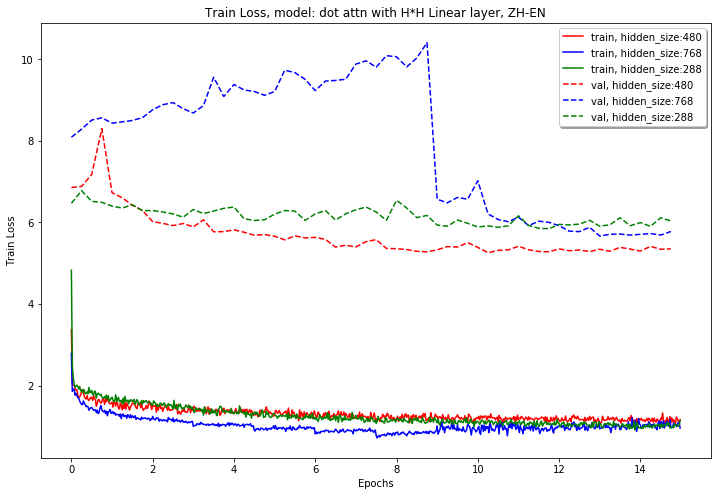

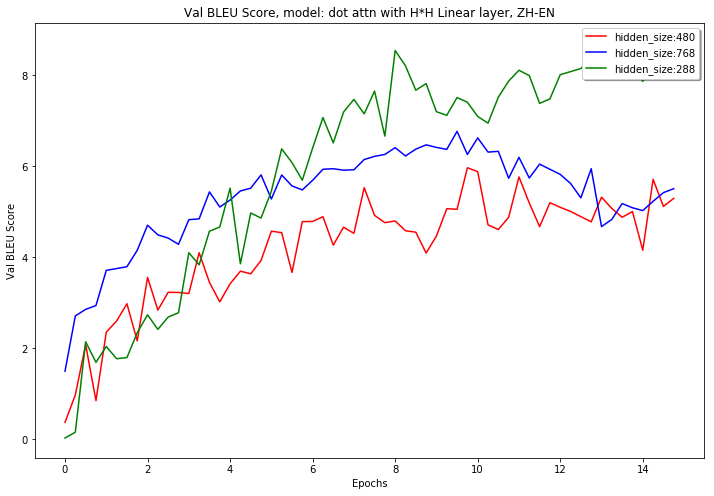

In [91]:
loss_plotter(dict_out_W, 'dot attn with H*H Linear layer, ZH-EN')

In [172]:
dict_out_vi = {}

In [177]:
recursive_reader(res_dataDir_vi, dict_out_vi, [], ['_2.p', '_3.p', '_4.p','_5.p'])

In [178]:
recursive_reader(res_dataDir, dict_out_vi, [], ['_2.p', '_3.p', '_4.p', '_5.p', 'zh_'], datadir_exclude='vi_new_attn')

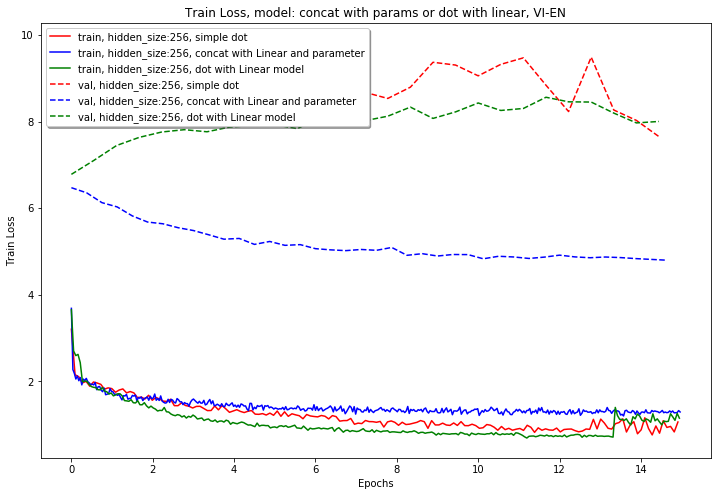

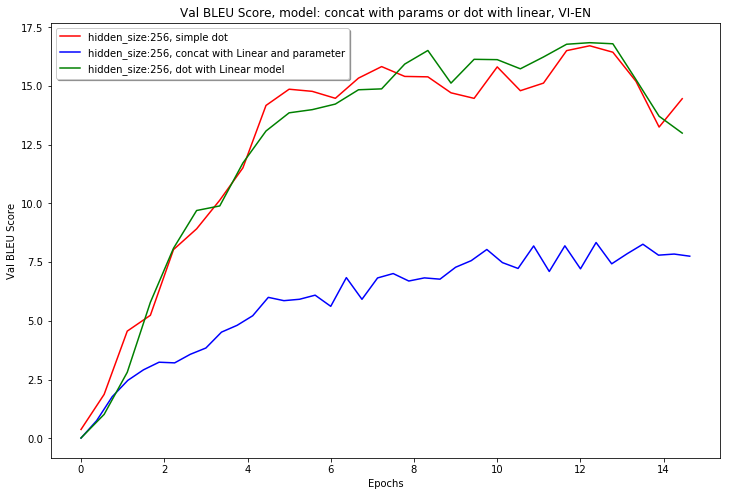

In [214]:
loss_plotter(dict_out_vi, 'concat with params or dot with linear, VI-EN')